# Data Exploratory
- read the csv file
- merge to create a single dataframe

In [13]:
import pandas as pd
import seaborn as sns

In [14]:
store = pd.read_csv('../data/store.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_62005/4126475691.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv')


In [21]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


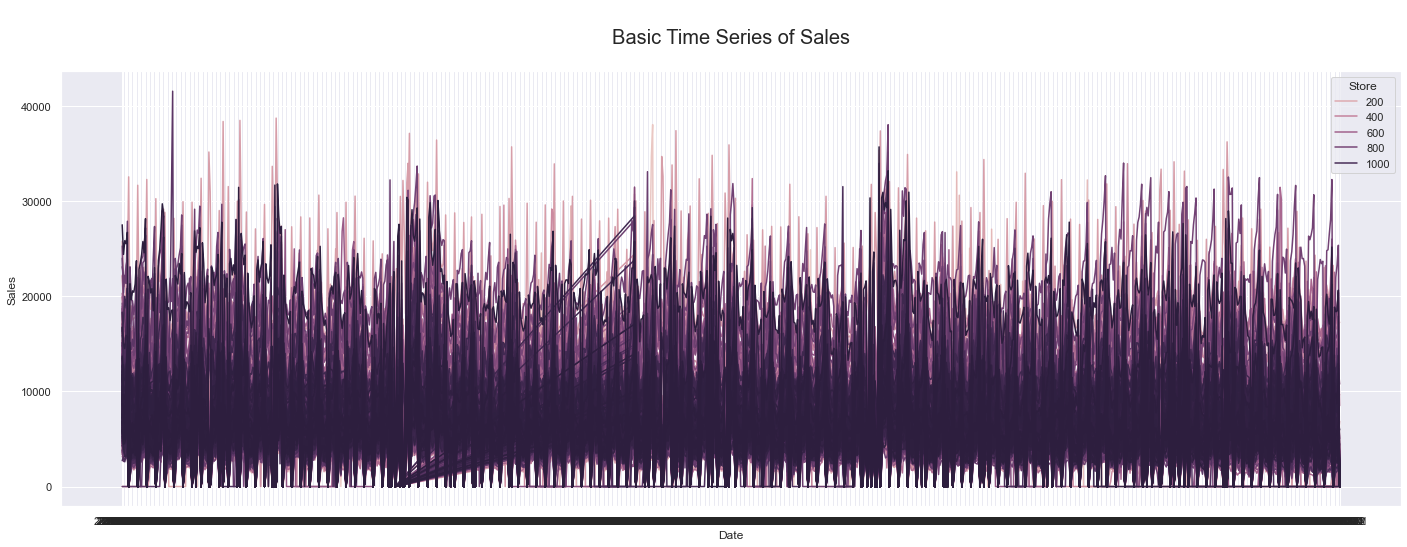

In [18]:
sns.set(rc={'figure.figsize':(24,8)})
ax = sns.lineplot(data=train, x='Date', y='Sales', hue='Store')
ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20)

In [22]:

store.head(100)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
95,96,a,a,8780.0,2.0,2005.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
96,97,d,c,8980.0,NaN,NaN,0,NaN,NaN,NaN
97,98,d,c,15140.0,12.0,2006.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
98,99,c,c,2030.0,11.0,2003.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [ ]:
train['']

In [12]:
# train_df = pd.merge(train, store, how='inner', on='Store')
# train_df.head()
